# CIFAR-10 dataset - VGG16 with Data Augmentation

In this notebook, we are going to assess the performances of VGG16 for image classifications on the images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. 

The experimental process is the following:

- Import CIFAR-10 dataset
- Pre-process the data 
    - Normalization of the images
    - One hot encoding of the labels
- Augment the data with random:
    - Rotations
    - Shifts
    - Scale Variation (zoom)
    - Flips
- Import the base model pre trained on Image Net
- Freeze the weights 
- Add a simple output network
- Fine tune the overall network by training the last layer
- Analyse results

All the implementation will be carried out in Keras (tensorflow backend) on our personal laptop. 

## Data Import

The utilities function to download the dataset have been reused from the code shared by Park Chansung through [his medium article](https://towardsdatascience.com/transfer-learning-in-tensorflow-9e4f7eae3bb4).

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num
        
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [5]:
image_size = 32

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, image_size, image_size)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

## Preprocess the Data to Merge Batches and Prepare the Split

The CIFAR dataset is provided divided into multiple files (batches). We will now merge all the batches into one single set of training data. Given the utilities provided by Keras we do not need to apply any Train-Validation split as it will be automatically be performed by the training procedure.

This does introduce a small bias due to the fact that validation items are normalised together with the training data and not separately. Given that the validation split only compares the model with itself we do not need to take care about this bias as long as its existance is acknowledged when evaluating the absolute value of the validation loss.

The test data is also loaded and preprocessed independently.

In [6]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical
from copy import deepcopy
import time

session_id = int(time.time())

def preprocess_and_save(features, labels, filename=None):
    features = preprocess_input(features)
    labels = to_categorical(labels)
    if filename is not None:
        pickle.dump((features, labels), open(filename, 'wb'))
    return features, labels

def build_and_save_splits(cifar10_dataset_folder_path):
    n_batches = 5
    valid_features = []
    valid_labels = []
    features = np.empty((0,32,32,3))
    labels = []
    
    for batch_i in range(1, n_batches + 1):
        features_, labels_ = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        features = np.concatenate((features,features_))
        labels += labels_
    
    original_features = deepcopy(features)
    # validation_size = int(len(features) * 0.1)
    X_train, y_train = preprocess_and_save(features, labels, "data/{}-train.pkl".format(session_id))
    # X_val, y_val = preprocess_and_save(features[-validation_size:], labels[-validation_size:], "data/validation.pkl")

    
    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']
    original_test_features = deepcopy(test_features)
    
    # Preprocess and Save all testing data
    X_test, y_test = preprocess_and_save(np.array(test_features), np.array(test_labels),
                         'data/{}-test.pkl'.format(session_id))
    

/Users/nicovendramin/.pyenv/versions/3.7.5/envs/data_science/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/nicovendramin/.pyenv/versions/3.7.5/envs/data_science/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/nicovendramin/.pyenv/versions/3.7.5/envs/data_science/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.d

In [64]:
build_and_save_splits(cifar10_dataset_folder_path)

## Checkpoint


In [1]:
# Run this cell with the timestamp of the run to be loaded if you want to load a different checkpoint
if False:
    session_id = 1596617066

In [31]:
import pickle

X_train, y_train = pickle.load(open('data/{}-train.pkl'.format(session_id), mode='rb'))
# X_val, y_val = pickle.load(open('data/validation.pkl', mode='rb'))
X_test, y_test = pickle.load(open('data/{}-test.pkl'.format(session_id), mode='rb'))

In [9]:
from tensorflow.keras.applications import vgg16

# Init the VGG model 
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x117a89450> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x117a85a90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x116bf24d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x10ab51990> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x134f5a050> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x143e2cbd0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x143e6cd50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x143e8ca10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x143ec4150> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x143efe450> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x143f31490> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x143f31f50> False
<tensorflow.py

In [11]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

# Create the model
model = Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(10, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 15,250,250
Trainable params: 535,562
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
from tensorflow.keras import optimizers

model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

In [32]:
eighty = int(80*len(X_train)/100)
X_val, y_val = X_train[eighty:], y_train[eighty:]
X_train, y_train = X_train[:eighty], y_train[:eighty]

print(X_train.shape)

(40000, 32, 32, 3)


In [21]:
training_data = None
training_labels = None

# We add the equivalent of 50% of the training data in augmented batches
total_batches = int(len(X_train) / 256 / 2)
for batch in range(0, total_batches):
    print("{}/{} ({:.2f}%)".format(batch, total_batches, batch/total_batches*100))
    x_batch, y_batch = generator.flow(X_train, y_train, batch_size=256).next()
    if training_data is None:
        training_data = np.copy(x_batch)
        training_labels = np.copy(y_batch)
    else:
        training_data = np.concatenate((training_data, x_batch))
        training_labels = np.concatenate((training_labels, y_batch))

print(training_data.shape)
print(training_labels.shape)

0/78 (0.00%)
1/78 (0.01%)
2/78 (0.03%)
3/78 (0.04%)
4/78 (0.05%)
5/78 (0.06%)
6/78 (0.08%)
7/78 (0.09%)
8/78 (0.10%)
9/78 (0.12%)
10/78 (0.13%)
11/78 (0.14%)
12/78 (0.15%)
13/78 (0.17%)
14/78 (0.18%)
15/78 (0.19%)
16/78 (0.21%)
17/78 (0.22%)
18/78 (0.23%)
19/78 (0.24%)
20/78 (0.26%)
21/78 (0.27%)
22/78 (0.28%)
23/78 (0.29%)
24/78 (0.31%)
25/78 (0.32%)
26/78 (0.33%)
27/78 (0.35%)
28/78 (0.36%)
29/78 (0.37%)
30/78 (0.38%)
31/78 (0.40%)
32/78 (0.41%)
33/78 (0.42%)
34/78 (0.44%)
35/78 (0.45%)
36/78 (0.46%)
37/78 (0.47%)
38/78 (0.49%)
39/78 (0.50%)
40/78 (0.51%)
41/78 (0.53%)
42/78 (0.54%)
43/78 (0.55%)
44/78 (0.56%)
45/78 (0.58%)
46/78 (0.59%)
47/78 (0.60%)
48/78 (0.62%)
49/78 (0.63%)
50/78 (0.64%)
51/78 (0.65%)
52/78 (0.67%)
53/78 (0.68%)
54/78 (0.69%)
55/78 (0.71%)
56/78 (0.72%)
57/78 (0.73%)
58/78 (0.74%)
59/78 (0.76%)
60/78 (0.77%)
61/78 (0.78%)
62/78 (0.79%)
63/78 (0.81%)
64/78 (0.82%)
65/78 (0.83%)
66/78 (0.85%)
67/78 (0.86%)
68/78 (0.87%)
69/78 (0.88%)
70/78 (0.90%)
71/78 (0.91%)
72

In [33]:
X_train = np.concatenate((X_train, training_data))
y_train = np.concatenate((y_train, training_labels))

In [34]:
print(X_val.shape)
print(y_val.shape)

(10000, 32, 32, 3)
(10000, 10)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'models/vgg-model-augm-{}.h5'.format(session_id), 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

In [39]:
# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=256,
    epochs=30,
    callbacks=[checkpoint],
    verbose=1
)

Train on 59968 samples, validate on 10000 samples
Epoch 1/30
59968/59968 [==============================] - 446s 7ms/sample - loss: 1.0002 - acc: 0.6432 - val_loss: 0.9925 - val_acc: 0.6656
Epoch 2/30
59968/59968 [==============================] - 504s 8ms/sample - loss: 0.9902 - acc: 0.6468 - val_loss: 0.9925 - val_acc: 0.6631
Epoch 3/30
59968/59968 [==============================] - 498s 8ms/sample - loss: 0.9920 - acc: 0.6462 - val_loss: 0.9950 - val_acc: 0.6589
Epoch 4/30
59968/59968 [==============================] - 472s 8ms/sample - loss: 0.9737 - acc: 0.6529 - val_loss: 0.9948 - val_acc: 0.6647
Epoch 5/30
59968/59968 [==============================] - 461s 8ms/sample - loss: 0.9731 - acc: 0.6520 - val_loss: 0.9914 - val_acc: 0.6648
Epoch 6/30
59968/59968 [==============================] - 485s 8ms/sample - loss: 0.9641 - acc: 0.6559 - val_loss: 0.9988 - val_acc: 0.6640
Epoch 7/30
59968/59968 [==============================] - 479s 8ms/sample - loss: 0.9523 - acc: 0.6570 - val_l

### Show Stats


<AxesSubplot:>

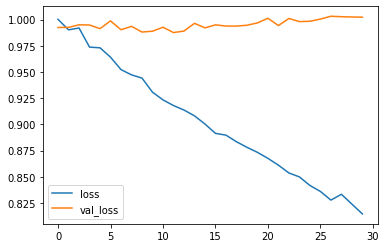

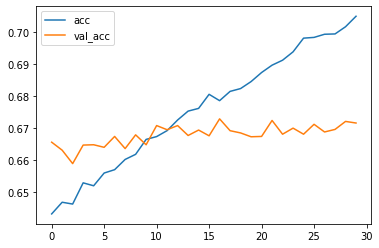

In [40]:
import json
import pandas as pd
#with open('history.json', 'w') as f:
#    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

### Fully Train the Model

In [41]:
model.load_weights('models/vgg-model-augm-{}.h5'.format(session_id))
train_loss, train_score = model.evaluate(X_train, y_train)
test_loss, test_score = model.evaluate(X_test, y_test)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)
print("Train F1 Score:", train_score)
print("Test F1 Score:", test_score)

10000/10000 [==============================] - 60s 6ms/sample - loss: 1.0044 - acc: 0.6630
Train Loss: 0.6393232362756353
Test Loss: 1.0043911428451537
Train F1 Score: 0.78543556
Test F1 Score: 0.663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Example of Image:
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane
Predicted Label - Label Id: 0 Name: airplane


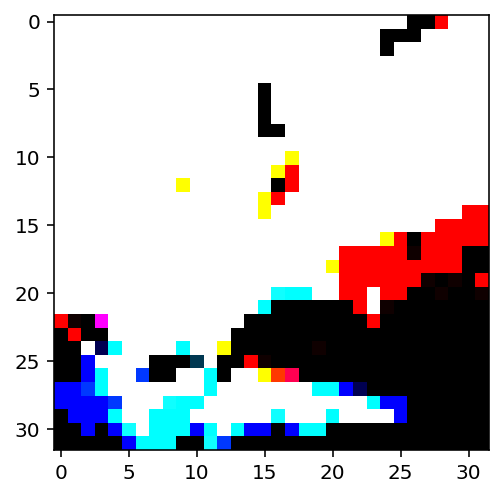

In [44]:
def predict_vector(sample):
    vector = model.predict(np.reshape(sample, (1,32,32,3)))[0]
    return vector

def predict_label(sample):
    vector = model.predict(np.reshape(sample, (1,32,32,3)))[0]
    return to_label_id(vector)
    
def to_label_id(label_vector):
    return np.argmax(label_vector)

def display_stats(sample_image, sample_label, predicted_label):
    
    label_names = load_label_names()
    
    print('\nExample of Image:')
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    print('Predicted Label - Label Id: {} Name: {}'.format(predicted_label, label_names[predicted_label]))
    
    plt.imshow(sample_image)
    
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
import random
image_id = random.randint(0, len(X_test))
display_stats(X_train[image_id], to_label_id(y_train[image_id]), predict_label(X_train[image_id]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


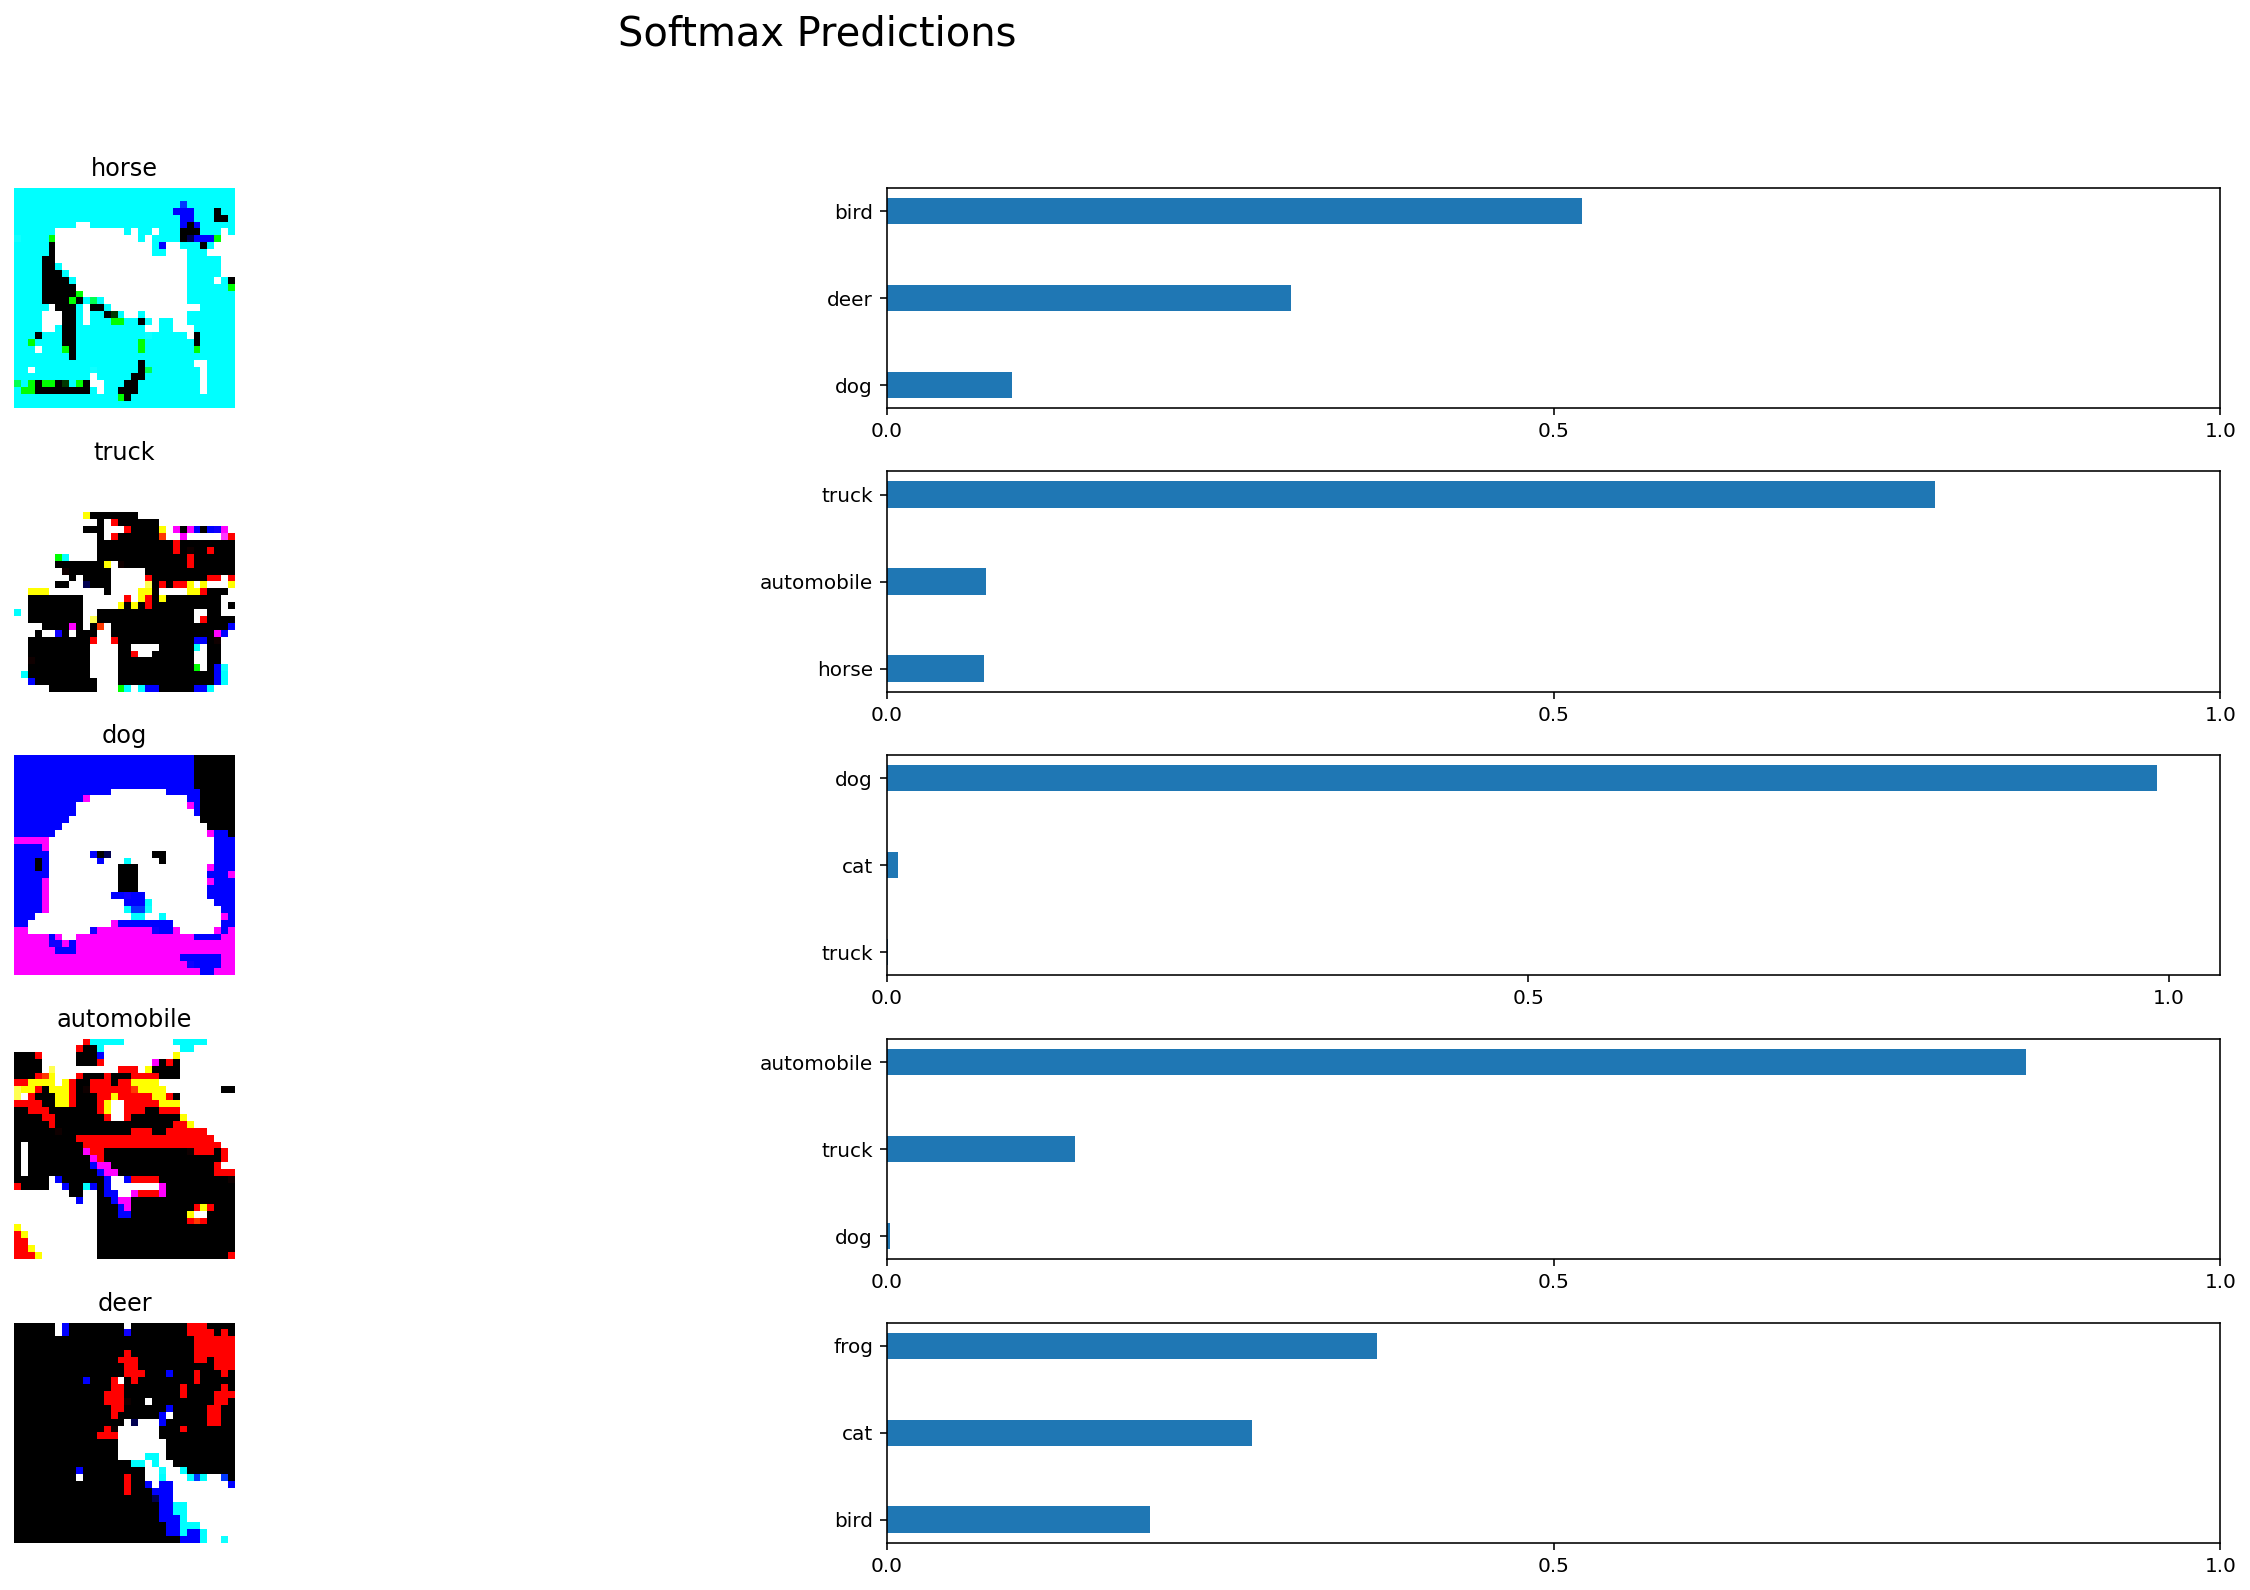

In [45]:
import random

def random_sample(X, y, k):
    a = list(np.arange(0, len(X)))
    c = random.sample(a, k)
    sample_X = []
    sample_y = []
    for i in c:
        sample_X.append(X[i])
        sample_y.append(y[i])
    return sample_X, sample_y

random_sample(X_test, y_test, 12)

def display_image_predictions(features, labels, top_n_predictions):
    n_classes = 10
    label_names = load_label_names()
    label_ids = [to_label_id(label) for label in labels]
    predictions = [predict_vector(feature) for feature in features]
    predictions_indices = []
    predictions_values = []
    for prediction in predictions:
        a = np.arange(0, len(prediction))
        b = list(zip(list(a), prediction))
        b = sorted(b, key=lambda x: x[1])
        c = list(map(lambda x: x[0], b))
        d = list(map(lambda x: x[1], b))
        predictions_indices.append(c[-top_n_predictions:])
        predictions_values.append(d[-top_n_predictions:])
        
    fig, axies = plt.subplots(nrows=top_n_predictions, ncols=2, figsize=(20, 10))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
   
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions_indices, predictions_values)):
        if (image_i < top_n_predictions):
            pred_names = [label_names[pred_i] for pred_i in pred_indicies]
            correct_name = label_names[label_id]
            
            axies[image_i][0].imshow((feature*255).astype(np.int32, copy=False))
            axies[image_i][0].set_title(correct_name)
            axies[image_i][0].set_axis_off()

            axies[image_i][1].barh(ind + margin, pred_values[-3:], width)
            axies[image_i][1].set_yticks(ind + margin)
            axies[image_i][1].set_yticklabels(pred_names[-3:])
            axies[image_i][1].set_xticks([0, 0.5, 1.0])

features_, labels_ = random_sample(X_test, y_test, 12)

display_image_predictions(features_, labels_, 5)


In [46]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    #Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

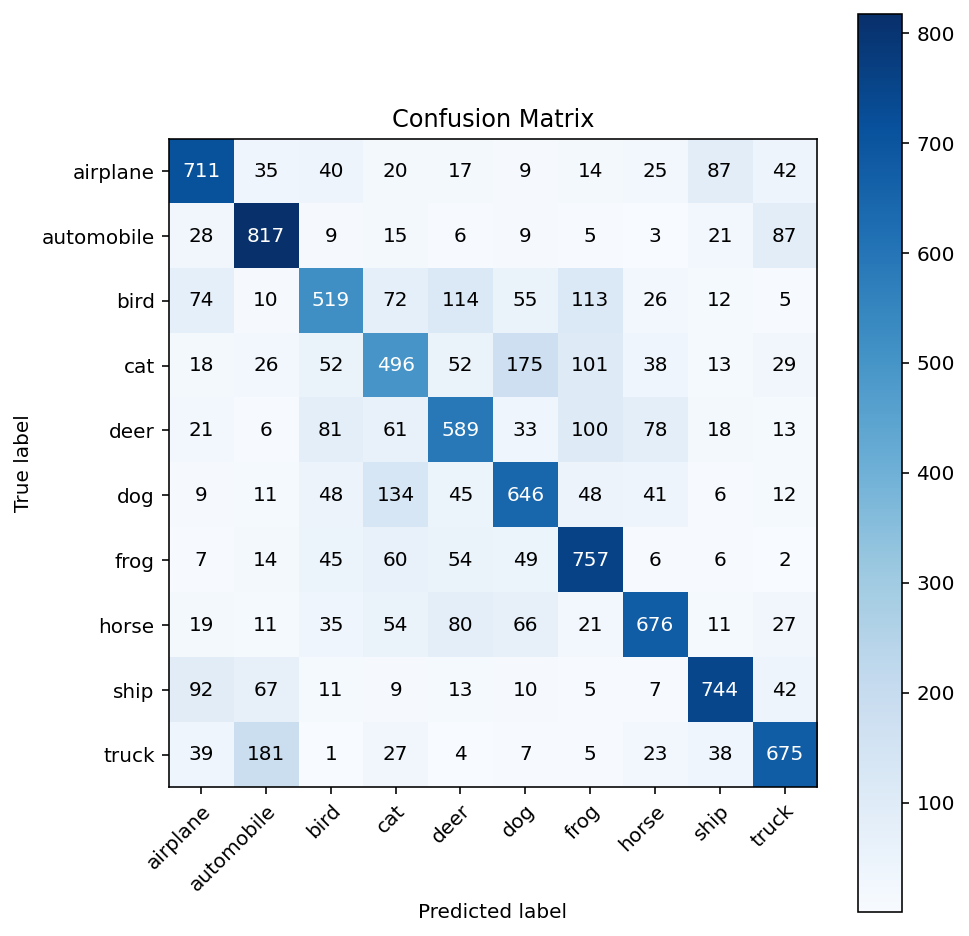

In [47]:
#Making prediction
y_pred=model.predict_classes(X_test)
y_true=np.argmax(y_test,axis=1)

#Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx=confusion_matrix(y_true,y_pred)

class_names= load_label_names()

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names)